In [1]:
import torch
import urllib.request
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torchvision.transforms import v2

In [2]:
#load images from wikimedia

url_list = ["https://upload.wikimedia.org/wikipedia/commons/thumb/1/1a/Ambulance_in_Abu_Dhabi_04.JPG/1280px-Ambulance_in_Abu_Dhabi_04.JPG",
            "https://upload.wikimedia.org/wikipedia/commons/thumb/6/6b/%C3%85land_ambulance_04.jpg/1280px-%C3%85land_ambulance_04.jpg",
            "https://upload.wikimedia.org/wikipedia/commons/3/31/Nueva_ambulancia_del_SAME.jpg",
            "https://upload.wikimedia.org/wikipedia/commons/thumb/7/71/Ambulance_of_New_South_Wales%2C_01.jpg/1280px-Ambulance_of_New_South_Wales%2C_01.jpg"]

file_list = []

for val, url in enumerate(url_list):
  filename = f"dog_{val}.jpg"
  file_list.append(filename)
  urllib.request.urlretrieve(url, filename)


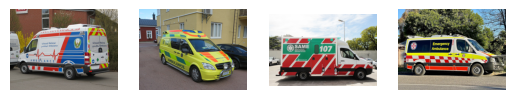

In [3]:
#view the PIL images before transforms

fig, axs = plt.subplots(1, len(file_list))

for i in range(len(file_list)):
  axs[i].imshow(Image.open(file_list[i]))
  axs[i].axis('off')  # Turn off axis labels

plt.show()

In [4]:
transform = v2.Compose([
              v2.Resize(560, interpolation=v2.InterpolationMode.BICUBIC),
              v2.CenterCrop(560),
              v2.ToTensor(),
              v2.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ])

batch_size = len(file_list)
imgs_tensor = torch.zeros(batch_size, 3, 560, 560)

for i in range(batch_size):
    img = Image.open(file_list[i])
    imgs_tensor[i] = transform(img)

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


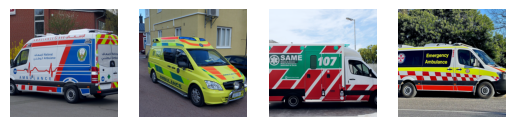

In [5]:
#To view the images after transforms, need to reverse normalization

fig, axs = plt.subplots(1, len(file_list))

for i in range(len(file_list)):
  img_t = (imgs_tensor[i]*0.23+0.4)
  axs[i].imshow(img_t.permute(1,2,0))
  axs[i].axis('off')  # Turn off axis labels

plt.show()

In [6]:
#load large DinoV2 model
dino = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')
dino.cuda()

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-23): 24 x NestedTensorBlock(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )


In [7]:
#Inference
with torch.no_grad():
  features_dict = dino.forward_features(imgs_tensor.cuda())
  features = features_dict['x_norm_patchtokens']

print("before reshape", features.shape)
_, n_patch, dim = features.shape
features = features.reshape(batch_size*n_patch, dim)
print("after reshape", features.shape)

before reshape torch.Size([4, 1600, 1024])
after reshape torch.Size([6400, 1024])


In [8]:
import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

In [9]:
features = features.cpu()
pca = PCA(n_components=1)
scaler = MinMaxScaler()
pca.fit(features)
pca_features = pca.transform(features)
norm_features = scaler.fit_transform(pca_features)

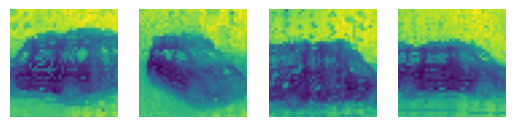

In [10]:
#view the normalized features after transforms

fig, axs = plt.subplots(1, batch_size)

for i in range(batch_size):
  img = pca_features[i * n_patch: (i+1) * n_patch, 0].reshape(40, 40)
  axs[i].imshow(img)
  axs[i].axis('off')  # Turn off axis labels

plt.show()

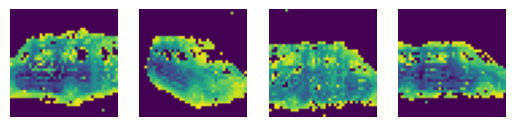

In [11]:
# Remove background
threshold = 0.5 #for ViTl/14
background = norm_features > threshold #Adjust threshold based on your images

fig, axs = plt.subplots(1, batch_size)

for i in range(batch_size):
  img = norm_features[i * n_patch: (i+1) * n_patch]
  #mask = background[i * n_patch: (i+1) * n_patch]
  img[img>threshold] = 0
  axs[i].imshow(img.reshape(40, 40))
  axs[i].axis('off')  # Turn off axis labels

plt.show()

In [12]:
#set background of features to zero

bg_features = features.clone() #make a copy of features
for i in range(bg_features.shape[-1]):
  bg_features[:,i][background[:,0]] = 0

In [13]:
#fit 3 components
pca3 = PCA(n_components=7)
pca3.fit(bg_features)
features_foreground = pca3.transform(bg_features)
norm_features_foreground = scaler.fit_transform(features_foreground)

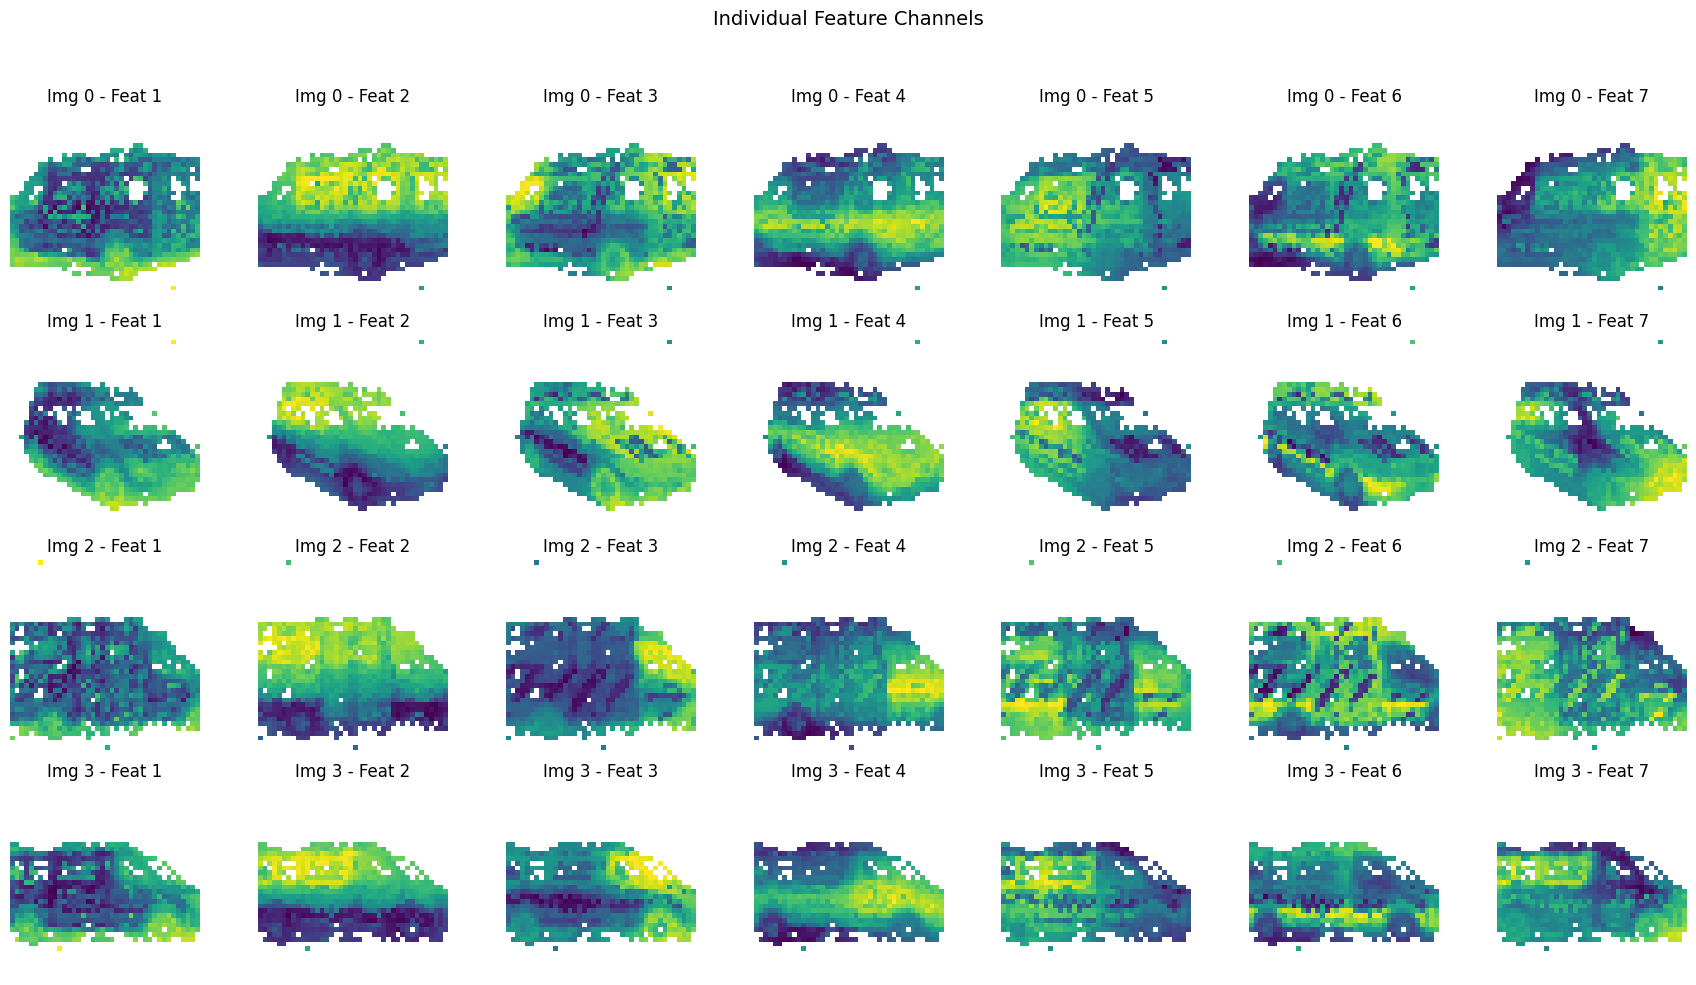

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# --- Your existing code ---
# Assuming norm_features_foreground, background, batch_size, n_patch exist.

# --- Modifications ---

# We need 5 columns per image in the batch
fig, axs = plt.subplots(batch_size, 7, figsize=(7 * 2.5, batch_size * 2.5)) # Adjust figsize

# Handle case where batch_size=1, axs isn't 2D array
if batch_size == 1:
    axs = np.array([axs]) # Make it a 2D array with one row

fig.suptitle("Individual Feature Channels", fontsize=14)

for i in range(batch_size):
    # Get the 5D features for the current image
    img_5d_flat = norm_features_foreground[i * n_patch: (i+1) * n_patch].copy()
    mask = background[i * n_patch: (i+1) * n_patch]
    mask_bool = mask[:, 0].astype(bool)

    # Set masked pixels to a value (e.g., NaN or min value for visualization)
    # Using NaN makes them transparent/white in some colormaps with imshow's handling
    img_5d_flat[mask_bool] = np.nan # Or set to 0 or a specific value

    for j in range(7): # Loop through the 5 features
        # Get the j-th feature channel
        feature_channel = img_5d_flat[:, j]

        # Reshape to image dimensions (Height, Width)
        img_to_display = feature_channel.reshape(40, 40)

        # Display using a grayscale or other sequential colormap
        im = axs[i, j].imshow(img_to_display, cmap='viridis', vmin=np.nanmin(img_to_display), vmax=np.nanmax(img_to_display))
        # plt.colorbar(im, ax=axs[i,j]) # Optional: add colorbar to each
        axs[i, j].set_title(f'Img {i} - Feat {j+1}')
        axs[i, j].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust layout
plt.show()

In [15]:
# Assuming raw_features_new_image has the same number of columns as the original bg_features
filename = f"ambulance_{val}.jpg"
urllib.request.urlretrieve("https://thumbs.dreamstime.com/b/rear-view-white-mercedes-benz-sprinter-ambulance-car-parked-near-hospital-havirov-czechia-september-352370892.jpg", filename)

new_img = Image.open(filename)
new_imgs_tensor = transform(img)

with torch.no_grad():
  features_dict = dino.forward_features(imgs_tensor.cuda())
  raw_features_new_image = features_dict['x_norm_patchtokens']

print("before reshape", raw_features_new_image.shape)
_, n_patch, dim = raw_features_new_image.shape
raw_features_new_image = raw_features_new_image.reshape(batch_size*n_patch, dim).cpu()
print("after reshape", raw_features_new_image.shape)

new_pca_features = pca3.transform(raw_features_new_image)
# new_pca_features will have shape (n_patches_new_image, 5)

before reshape torch.Size([4, 1600, 1024])
after reshape torch.Size([6400, 1024])


In [16]:
import matplotlib.pyplot as plt
import numpy as np

feature_5_new = new_pca_features[:, 4]

# --- You need the mask for the NEW image ---
# mask_new_image = calculate_mask(new_image) # Pseudocode
# mask_new_image_flat = mask_new_image.flatten() # Assuming patch-based
# feature_5_new[mask_new_image_flat] = np.nan # Or 0, etc.

# Reshape to the new image's patch layout (e.g., 40x40 if applicable)
# This assumes the new image yields the same number of patches (1600)
# Adjust height/width if the new image size/patching is different
height_new, width_new = 40, 40 # Example
img_to_display = feature_5_new.reshape(height_new, width_new)

plt.figure()
plt.imshow(img_to_display, cmap='viridis') # Or 'gray' etc.
plt.title("Feature 5 (from old PCA) on New Image")
plt.colorbar()
plt.axis('off')
plt.show()

ValueError: cannot reshape array of size 6400 into shape (40,40)